# Assignment 6

Jacivania Cordeiro Nunes, Matr. 9040898

## General:

Used Python libraries:
- Matplotlib (V3.5.1; https://matplotlib.org)
- NumPy (V1.21.5; https://numpy.org)
- Pandas (V1.4.2; https://pandas.pydata.org)
- SciPy (V1.7.3; https://scipy.org)

Used external resources:
- https://www.geeksforgeeks.org/different-ways-to-iterate-over-rows-in-pandas-dataframe/
- https://machinelearningmastery.com/how-to-use-nelder-mead-optimization-in-python/

In [41]:
# General setup, helper functions, etc.
import matplotlib.pyplot as plot, numpy as np, pandas as pd, scipy.optimize as opt

# Define constants and load data:

# Molecule bond parameters loaded from disk
try:
    params = pd.read_csv('C:\\Users\\Jacivania Nunes\\Desktop\\Studium\\Semester 4\\Scientific_Programming_with_Python\\6\\parameters.csv')
except Exception as err:
    raise RuntimeError("Parameters file parameters.csv couldn't be loaded")

# Ethanol atom bond distances loaded from disk
try:
    distances = pd.read_csv('C:\\Users\\Jacivania Nunes\\Desktop\\Studium\\Semester 4\\Scientific_Programming_with_Python\\6\\model_distances.csv')
except Exception as err:
    raise RuntimeError("Distances file model_distances.csv couldn't be loaded")

# Cubic force constant assumed for ethanol
Cr = -0.45 # 1/A

# Gets the force constant and equilibrium distance of the given bond type
# Parameters:
#   bond_type: The bond type as a string
# Returns:
#  (force constant: float, equilibrium distance: float) as a tuple
# If the bond type doesn't exist, a RuntimeError is thrown.
def get_bond_values(bond_type: str) -> (float, float):
    # Check if a bond type was actually specified
    if bond_type == "":
        raise ValueError("bond_type may not be empty")
        
    # Try to get the values out of params; if no values are found (or too many), a RuntimeError is thrown
    values = params.loc[params["Bond Type"] == bond_type]
    if len(values.index) != 1:
        raise RuntimeError(f"No or too many parameters found for bond type {bond_type}")
        
    # Everything went smooth, return the values as a tuple
    np_vals = values.to_numpy() # Cast to NumPy array for easier value access
    return (np_vals[0][1], np_vals[0][2]) # Only one row at index 0; returned array contains force const. at index 1, eq. dist. at index 2

The following function calculates the bond energy for a given distance and the bond's force constant and equilibrium distance.

In [7]:
# Calculates the potential bond energy given the atom distance and the bond's force constant and equilibrium distance
# Parameters:
#   distance: Current distance between atoms
#   force_const: Force constant
#   equi_dist: Equilibrium distance
# Returns:
#  Potential bond energy as a float
def calc_bond_energy(distance: float, force_const: float, equi_dist: float) -> float:
    # Calculate energy using the following formula:
    #   E = Hr(r-r_eq)^2 + HrCr(r-r_eq)^3
    return force_const * (distance-equi_dist)**2 + force_const * Cr * (distance-equi_dist)**3

## Task 1

This task calculates potential bond energies for a set of atom bonds (C-C, C-H, O-H, C-O) in ethanol for a range of bond distances and shows them in a combined line plot.

The code uses two helper functions to achieve this: `get_bond_values` which fetches the force constant and equilibrium distance for a given bond type, as well as `calc_bond_energy` to calculate the potential energy for a given atom-to-atom distance.

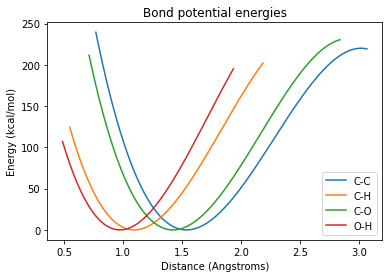

In [17]:
# Creates a plot showing how the bond potential energy (y-axis) relates to the atom distance (x-axis) of a given bond type
# Parameters:
#   bond_type: The bond type as a string
# Returns:
#  None
# If the bond type doesn't exist, a RuntimeError is thrown.
def plot_bond_energies(bond_type: str) -> None:
    # Check if a bond type was actually specified
    if bond_type == "":
        raise ValueError("bond_type may not be empty")
    
    # Get bond type values
    force_const, equi_dist = get_bond_values(bond_type) # Raises an exception for invalid bond types
    
    # First, calculate a meaningful distance range we want to plot - from r_eq/2 to r_eq*2
    min_range = equi_dist / 2
    max_range = equi_dist * 2
    
    # Create an array of function argument values to plot
    distance_values = np.arange(min_range, max_range, 0.01) # Use small steps for a smoother graph
    
    # Calculate the energy values for each distance value 
    energy_values = [calc_bond_energy(dist, force_const, equi_dist) for dist in distance_values]
    
    # Finally, create the plot!
    plot.plot(distance_values, energy_values, label=bond_type)

# Create all plots for each bond type found in params; this also avoids any runtime exceptions, as the bond types always exist
for bond_type in params["Bond Type"]:
    plot_bond_energies(bond_type)

# Make the plot more informative
plot.title('Bond potential energies')
plot.xlabel('Distance (Angstroms)')
plot.ylabel('Energy (kcal/mol)')
plot.legend()
plot.show()
    

# Task 2

Below code iterates over all bonds found in an ethanol molecule and calculates the optimal atom pair distance for each bond using the Nelder-Mead algorithm.

The code re-uses our previous functions `get_bond_values` and `calc_bond_energy` to perform the optimization task.

In [42]:
# Iterate over all bonds in our given data table
#   Inspired by https://www.geeksforgeeks.org/different-ways-to-iterate-over-rows-in-pandas-dataframe/
for index, bond in distances.iterrows():
    # Get values from the current bond
    pair_name = bond["Atom Pair"]
    init_dist = bond["Initial Distance"]
    bond_type = bond["Bond Type"]
    
    # Get bond type values
    force_const, equi_dist = get_bond_values(bond_type) # Raises an exception for invalid bond types
    
    # Use the Nelder-Mead algorithm (from SciPy) to optimize our energy function for this bond
    #   Based on https://machinelearningmastery.com/how-to-use-nelder-mead-optimization-in-python/
    #
    # Since our energy function calc_bond_energy needs 3 params, we have to bind the second and third
    # one through a lambda; the values of the bound params are thus 'fixed'
    
    def x(d: float) -> float:
        return calc_bond_energy(d, force_const, equi_dist)
    
    # bond_energy_objective = lambda d : calc_bond_energy(d, force_const, equi_dist)
    result = opt.minimize(x, init_dist, method="nelder-mead")
    
    # Print the result
    print((
        f"Bond {pair_name} (type {bond_type}), initial distance={init_dist}:\n"
        f"\t{'Succeeded' if result['success'] else 'Failed'}: "
        f"optimal distance={result['x'][0]}, "
        f"energy={calc_bond_energy(result['x'][0], force_const, equi_dist)}\n")
    )


Bond C1-H1 (type C-H), initial distance=1.01:
	Succeeded: optimal distance=1.095021484375, energy=1.5384258307398915e-07

Bond C1-H2 (type C-H), initial distance=1.01:
	Succeeded: optimal distance=1.095021484375, energy=1.5384258307398915e-07

Bond C1-H3 (type C-H), initial distance=1.01:
	Succeeded: optimal distance=1.095021484375, energy=1.5384258307398915e-07

Bond C1-C2 (type C-C), initial distance=1.67:
	Succeeded: optimal distance=1.5379819335937495, energy=9.821306442875475e-08

Bond C2-H4 (type C-H), initial distance=1.02:
	Succeeded: optimal distance=1.095005859375, energy=1.1442917216187473e-08

Bond C2-H5 (type C-H), initial distance=1.02:
	Succeeded: optimal distance=1.095005859375, energy=1.1442917216187473e-08

Bond C2-O1 (type C-O), initial distance=1.41:
	Succeeded: optimal distance=1.42301220703125, energy=4.719171826798404e-08

Bond O1-H6 (type O-H), initial distance=1.41:
	Succeeded: optimal distance=0.9730239257812492, energy=2.1260304427733218e-07



# Conclusion

As expected, the calculated optimal distances (with respect to the pot. energy) are close to the equilibrium distances, as the energy formula yields zero for these values.